In [1]:
from school_analysis.preprocessing.load import Loader
import pandas as pd


loader = Loader()
melted_df = loader.load('number_of_repeaters')


melted_df['year'] = pd.to_datetime(melted_df['year'], format='%Y')
melted_df['total'] = pd.to_numeric(melted_df['total'], errors='coerce')
total_over_years = melted_df.groupby('year')['total'].sum()

children_state = loader.load('school-children-by-state')
children_state = children_state.rename(columns={'Year': 'year'})
children_state['year'] = pd.to_datetime(children_state['year'], format='%Y')
child_amount_per_year = children_state.groupby('year')['Value'].sum()

df_repeaters = pd.merge(total_over_years, child_amount_per_year, on='year')
df_repeaters['relative'] = df_repeaters['total']/df_repeaters['Value'] 

C:\Users\jonas\AppData\Local\Temp\ipykernel_17528\143647358.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # Stellt sicher, dass alles gut im Plot passt


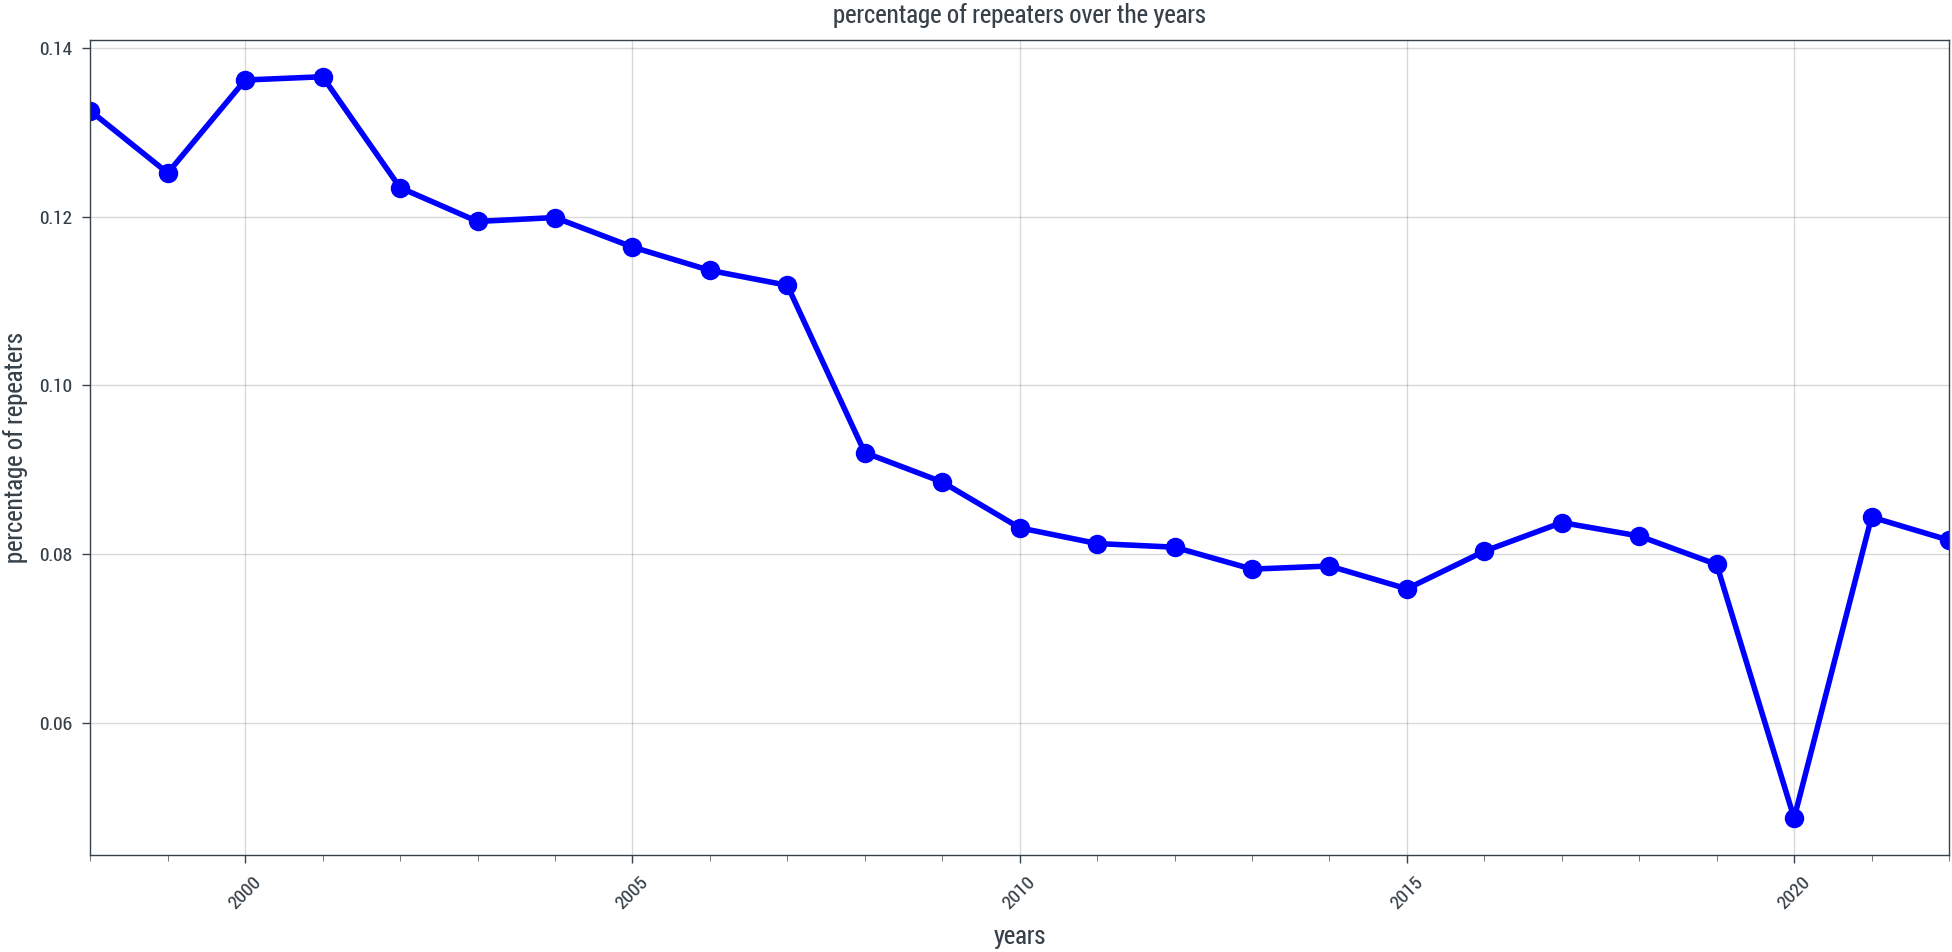

In [2]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))
df_repeaters['relative'].plot(kind='line', marker='o', color='blue', linewidth=2)
plt.title('percentage of repeaters over the years')
plt.xlabel('years')
plt.ylabel('percentage of repeaters')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  # Stellt sicher, dass alles gut im Plot passt
plt.show()